In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import pingouin as pg
import statsmodels
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%matplotlib inline

# Рост певцов хора

В 1979 году было опрошено 235 членов нью-йоркской ассоциации хорового пения, для каждого из них известен рост и регистр голоса. Меняется ли средний рост вместе с регистром?

In [ ]:
singer = pd.read_csv('singer.csv', sep=',')

In [ ]:
singer.head()

,height,voice.part
0,64,Soprano 1
1,62,Soprano 1
2,66,Soprano 1
3,65,Soprano 1
4,60,Soprano 1


In [ ]:
singer['voice.part'].unique()

array(['Soprano 1', 'Soprano 2', 'Alto 1', 'Alto 2', 'Tenor 1', 'Tenor 2',
       'Bass 1', 'Bass 2'], dtype=object)

Для удобства переведем рост респондентов из дюймов в сантиметры.
Так как информация о регистре голоса является категориальным признаком, то переведем соответствующую колонку в соответствующий тип данных для удобства анализа.

In [ ]:
singer.height = singer.height*2.54
singer['voice.part'] = singer['voice.part'].astype('category')

Рассмотрим основные статистики и визуализируем распределение для каждого типа регистра голоса. Удобнее всего это сделать с помощью `describe()` и `boxplot`.

In [ ]:
singer.groupby("voice.part").describe()

height                                                          \
            count        mean       std     min      25%     50%      75%   
voice.part                                                                  
Alto 1       35.0  164.809714  7.098418  152.40  160.020  165.10  168.910   
Alto 2       27.0  167.734074  5.956057  160.02  162.560  167.64  170.180   
Bass 1       39.0  179.623590  5.997977  167.64  175.260  180.34  182.880   
Bass 2       26.0  181.316923  6.931061  167.64  177.800  182.88  187.960   
Soprano 1    36.0  163.195000  4.756751  152.40  159.385  165.10  165.100   
Soprano 2    30.0  162.475333  6.414775  152.40  157.480  162.56  167.005   
Tenor 1      21.0  175.018095  8.458801  162.56  167.640  172.72  180.340   
Tenor 2      21.0  177.558095  5.261220  167.64  175.260  175.26  180.340   

                    
               max  
voice.part          
Alto 1      182.88  
Alto 2      177.80  
Bass 1      190.50  
Bass 2      190.50  
Soprano 1   172.72  
Soprano 2   177.80  
Tenor 1     193.04  
Tenor 2     193.04

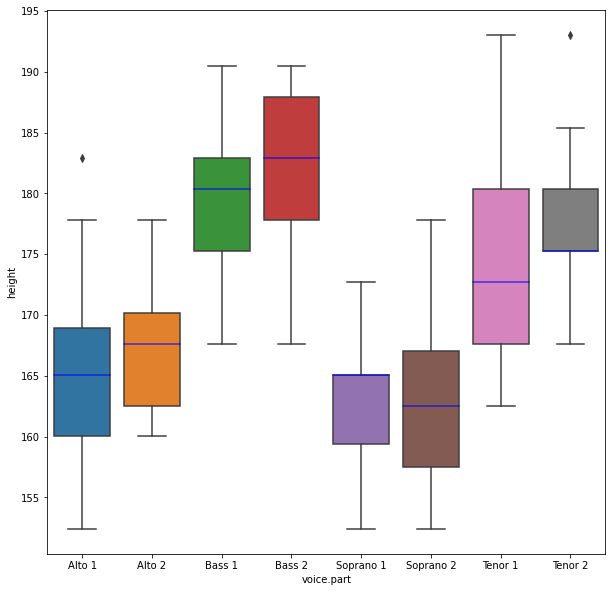

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='voice.part', y='height', data=singer, ax=ax, medianprops=dict(color='blue', alpha=0.7));

Визуально самый высокий рост наблюдается у людей с регистром голоса Bass. Alto и Soprano c более низким ростом. Причем отличия между типами регистра 1 и 2 не кажутся значительными.

Перед проверкой на равенство дисперсий и использованию ANOVA необходимо сделать проверку на нормальность. Посмотрим на распределение более подробно.

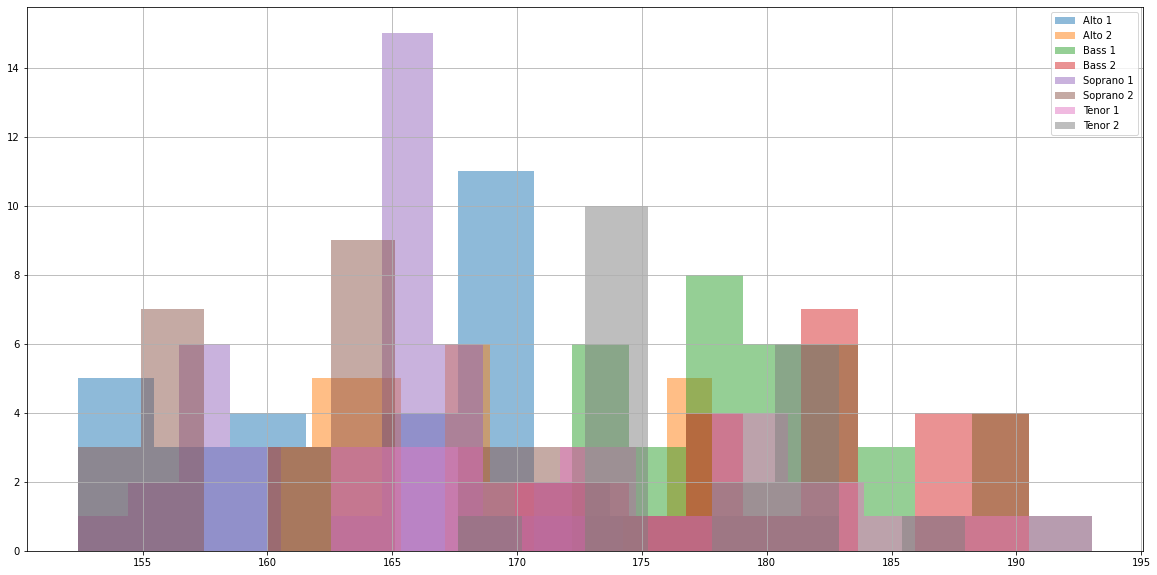

In [ ]:
groups = singer.groupby("voice.part")['height']
fig, ax = plt.subplots(figsize=(20,10))

for label, group in groups:
    group.hist(label=label, alpha=0.5, ax=ax)

ax.legend();

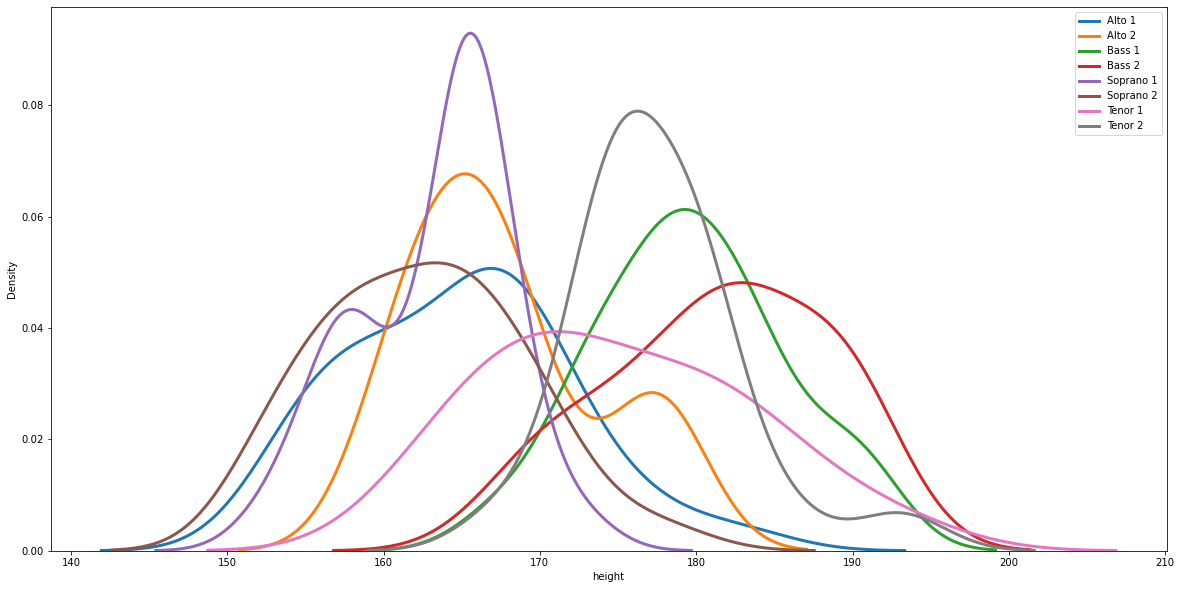

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
for label, group in groups:
    sns.kdeplot(group, label = label, ax=ax, linewidth=3)
    ax.legend()

Визуализации наших распределений, полученных с помощью ядерного сглаживания, дают нам информацию о том, что некоторые распределения могут быть не нормальными (видим ряд бимодальных распределений). Воспользуемся функцией `pg.normality` для теста на нормальность. Функция по дефолту использует тест Шапиро-Уилка.

In [ ]:
pg.normality(singer, dv="height", group="voice.part", alpha=0.01)

,W,pval,normal
Soprano 1,0.901836,0.003832,False
Soprano 2,0.967122,0.463724,True
Alto 1,0.968387,0.400495,True
Alto 2,0.871288,0.003132,False
Tenor 1,0.965708,0.637467,True
Tenor 2,0.889947,0.022446,True
Bass 1,0.958989,0.164986,True
Bass 2,0.928962,0.073209,True


-----
Если данные не имеют Гаусcово распределение, то

    1) можно воспользоваться преобразованием Бокса-Кокса:

$y(\lambda) = \begin{cases}
    (y^\lambda-1)/\lambda,& \text{if } \lambda\neq 0\\
    \log y,              & \text{if } \lambda= 0
\end{cases}$

    2) Воспользоваться критерием Краскела-Уоллиса

    3) Придумать отговорку

Преобразование Бокса-Кокса мы пока подробно не рассматривали в нашем курсе, но давайте рассмотрим возможность его использования. Это нужно для демонстрации того, что даже специальная обработка данных не всегда может работать на ваших данных.

In [ ]:
Soprano1, lmda, conf_int = stats.boxcox(singer.loc[singer['voice.part'] == 'Soprano 1'].height, alpha = 0.05)

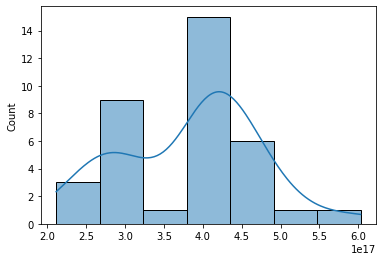

In [ ]:
sns.histplot(Soprano1, kde = True);

Так как преобразование Бокса-Кокса не сработало, то можем воспользоваться критерием Краскела-Уоллиса.

In [ ]:
pg.kruskal(singer, dv='height', between='voice.part')

,Source,ddof1,H,p-unc
Kruskal,voice.part,7,141.836221,2.095721e-27


Тогда нулевая гипотеза о том что распределения подвыборок имеют одинаковое смещение отвергается. Это означает, что наше разбиение по регистру голоса связано с ростом респондента.

-----
Для примера давайте проигнорируем информацию из тестов на нормальность и решим, что распределения Soprano 1 и Alto 2 все-таки являются нормальными (в домашних работах так делать не надо!).

Тогда далее необходимо проверить гипотезу о равенстве дисперсий (Бартлетта) и в случае, если эта гипотеза не отвергается, воспользоваться нормальным однофакторным дисперсионным анализом для проверки гипотезы о равнестве всех средних.  

In [ ]:
pg.homoscedasticity(singer,method='bartlett', dv='height', group='voice.part', alpha=0.05)

,T,pval,equal_var
bartlett,11.736,0.109566,True


Нулевая гипотеза о равенстве дисперсий не отвергается, следовательно можем приступать к построению anova.

----
Если равенства дисперсий нет:

   1) Воспользоваться критерием Краскела-Уоллиса
    
   2) Использовать `pg.welch_anova()` (https://www.researchgate.net/publication/228898214_How_to_keep_the_Type_I_Error_Rate_in_ANOVA_if_Variances_are_Heteroscedastic)
____

In [ ]:
pg.anova(dv='height', between='voice.part', data=singer)

,Source,ddof1,ddof2,F,p-unc,np2
0,voice.part,7,227,45.641891,5.617050e-40,0.584624


ddof1 - межгрупповаое кол-во степеней свободы (кол-во категориальных признаков - 1)

ddof2 - внутригупповое кол-во степеней свободы (кол-во респондентов - кол-во категориальных признаков)

F - значение статистики теста Фишера

p-unc - нескорректированное p-значение

np2 - частичный эта-квадрата, это доля дисперсии, которую объясняет переменная(общая дисперсия минус дисперсия, объясненная другими переменными). Значение  показателя находится в диапазоне от 0 до 1. Если значение близко к 1, то данная переменная объясняет высокую долю дисперсии.

Нулевая гипотеза о равенстве средних отвергается, то есть вывод остается прежним. Однако чем менее нормальны наши распределения для подвыборок, тем более вероятно отвержение нулевой гипотезы в нашем тесте. Поэтому необходимо всегда учитывать нормальность и не использовать anova на данных имеющих ненормальное распределение.

Если нас интересует информация об остатках, то мы можем вывести ее с помощью настройки `detailed=True`

In [ ]:
pg.anova(dv='height', between='voice.part', data=singer, detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,voice.part,12911.303982,7,1844.471997,45.641891,5.617050e-40,0.584624
1,Within,9173.483695,227,40.411822,NaN,NaN,NaN


Within - остатки, то есть отличия объекта от собственной группы.

SS - сумма квадратов отклонений  
MS - среднее значение квадрата отклонений  

# Влияние витамина C на рост зубов морских свинок

В эксперименте изучалось влияние витамина C на рост одонтобластов морских свинок.  

Рассматривалось три дозы витамина (0.5, 1 и 2 мг) и два способа его приёма (апельсиновый сок и аскорбиновая кислота). В каждой из 6 групп по уровням двух факторов были произведены измерения для 10 морских свинок.

In [ ]:
ToothGrowth = pd.read_csv('ToothGrowth.csv', sep=',')
ToothGrowth['dose'] = ToothGrowth['dose'].astype('category')
ToothGrowth['supp'] = ToothGrowth['supp'].astype('category')

Так как у нас мало данных внутри каждой группы (10 наблюдений) и ни один из тестов не обладает достаточной мощностью чтобы говорить о нормальности малой выборки, то будем исходить из предположения, что наши данные имеют нормальное распределение.

Как обычно - сначала исследуем распределение наших данных.

In [ ]:
ToothGrowth.describe()

,len
count,60.000000
mean,18.813333
std,7.649315
min,4.200000
25%,13.075000
50%,19.250000
75%,25.275000
max,33.900000


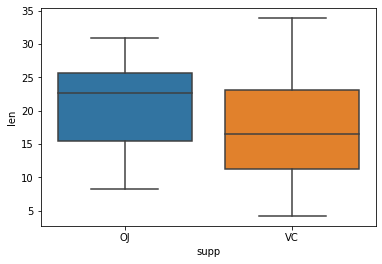

In [ ]:
sns.boxplot(x='supp', y='len',data=ToothGrowth);

Значимого отличия в среднем в целом не наблюдается для морских свинок с разными способами приема лекарства.

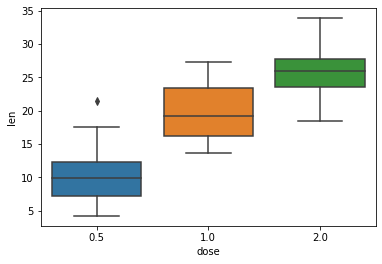

In [ ]:
sns.boxplot(x='dose', y='len',data=ToothGrowth);

Однако доза лекарства показывает нам, что рост одонтобластов зависит от кол-ва принимаемого лекарства.

Применим нормальный двухфакторный дисперсионный анализ учетом межфакторного взаимодействия. То есть нас интересует влияет ли доза  и способ приема в совокупности.

In [ ]:
pg.anova(dv='len', between=['dose', 'supp'], data=ToothGrowth,detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,dose,2426.434,2,1213.217,91.999952,4.046303e-18,0.773109
1,supp,205.350,1,205.350,15.571979,2.311828e-04,0.223825
2,dose * supp,108.319,2,54.160,4.107004,2.186003e-02,0.132028
3,Residual,712.106,54,13.187,NaN,NaN,NaN


Все исследуемые нами факторы значимо влияют на рост одонтобластов. Причем доза препарата значительно больше объясняет общую дисперсию, из которой иключено влияние других показателей (np2 очень близок к 1).

Межфакторное взаимодействие можно неплохо визуализировать для более-менее простых случаев c помощью команды interaction_plot. Получите графики зависимостей, если по оси x откладывать supp и если по оси x откладывать dose. Проинтерпретируйте полученные зависимости.

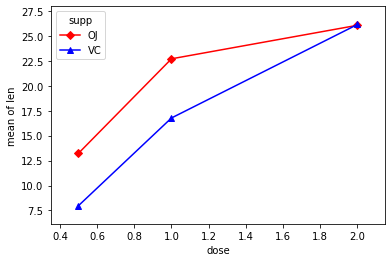

In [ ]:
statsmodels.graphics.factorplots.interaction_plot(ToothGrowth['dose'],
                                                  ToothGrowth['supp'],
                                                  ToothGrowth['len'],
                                                  colors=['red','blue'],
                                                  markers=['D','^'])
plt.show()

Для воможности визуализации переведем способ приема в бинарный вид.

In [ ]:
ToothGrowth['supp_codes'] = ToothGrowth['supp'].cat.codes

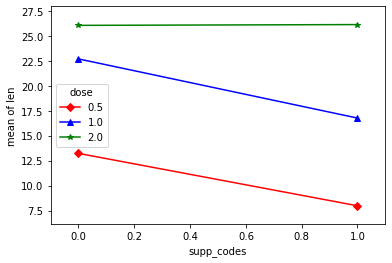

In [ ]:
statsmodels.graphics.factorplots.interaction_plot(ToothGrowth['supp_codes'],
                                                  ToothGrowth['dose'],
                                                  ToothGrowth['len'],
                                                  colors=['red','blue', 'green'],
                                                  markers=['D','^', '*'])
plt.show()

Взаимодействие значимо, поэтому разделим выборку по способу приёма витамина (колонка supp). Если бы взаимодействие не было значимым, то мы бы увидели параллельные друг другу линии на графике.

In [ ]:
OJ = ToothGrowth[ToothGrowth.supp == 'OJ']
VC = ToothGrowth[ToothGrowth.supp == 'VC']

Проведите дисперсионный анализ внутри каждой из групп:  

- Для морских свинок, принимающих аскорбиновую кислоту  

- Для морских свинок, принимающих апельсиновый сок

Вам нужно  

- Построить график зависимостей len ~ dose

- Построить anova модель len ~ dose. Посмотреть на вывод summary

- Провести тест kruskal

- Сделать выводы по для каждой из групп свинок

## Для морских свинок, принимающих аскорбиновую кислоту:

<AxesSubplot:xlabel='dose', ylabel='len'>

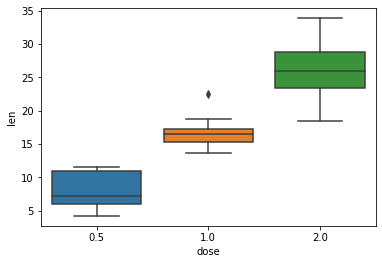

In [ ]:
sns.boxplot(x='dose', y='len',data=VC)

In [ ]:
pg.anova(dv='len', between=['dose'], data=VC, detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,dose,1649.488667,2,824.744333,67.072379,3.357317e-11,0.832449
1,Within,332.001000,27,12.296333,NaN,NaN,NaN


In [ ]:
pg.kruskal(VC, dv='len', between='dose')

,Source,ddof1,H,p-unc
Kruskal,dose,2,25.072217,0.000004


На морских свинок, принимающих аскорбиновую кислоту значимо влияет доза принимаемого лекарства.

## Для морских свинок, принимающих апельсиновый сок:

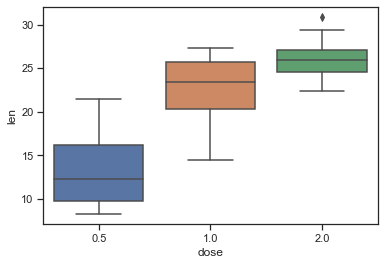

In [ ]:
sns.boxplot(x='dose', y='len',data=OJ);

In [ ]:
pg.anova(dv='len', between=['dose'], data=OJ, detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,dose,885.265,2,442.632,31.442,8.88716e-08,0.7
1,Within,380.105,27,14.078,-,-,-


In [ ]:
pg.kruskal(OJ, dv='len', between='dose')

,Source,ddof1,H,p-unc
Kruskal,dose,2,18.506,0.000096


На морских свинок, принимающих апельсиновый сок, значимо влияет доза принимаемого лекарства.

# Лечение гипертонии

72 пациента проходили лечение от гипертонии. Для лечения использовались три вида лекарств, при этом их эффект изучался как при использовании специальной диеты, так и в её отсутствии; кроме того, в половине случаев применялась психотерапия. Данные — артериальное давление пациента по окончании лечения.  

Требуется сравнить эффективность методов лечения гипертонии.  

In [ ]:
data = pd.read_table('hyper.txt', delimiter="\t")

In [ ]:
data.head()

,biofeedback,diet,drug,pressure
0,present,absent,1,170
1,present,absent,1,175
2,present,absent,1,165
3,present,absent,1,180
4,present,absent,1,160


In [ ]:
data.describe()

,drug,pressure
count,72.000000,72.000000
mean,2.000000,184.500000
std,0.822226,17.838872
min,1.000000,152.000000
25%,1.000000,170.750000
50%,2.000000,182.500000
75%,3.000000,198.250000
max,3.000000,228.000000


In [ ]:
data['drug'] = data['drug'].astype('category')

Проведите трехфакторный дисперсионный анализ, используя все взаимодействия ( biofeedback * diet * drug). Что можно сказать о значимости тройного взаимодействия? Можно ли интерпретировать значимость воздействия одиночных факторов в таком случае?

In [ ]:
pg.anova(dv='pressure', between=['biofeedback', 'diet', 'drug'], data=data)

,Source,SS,DF,MS,F,p-unc,np2
0,biofeedback,2048.0,1.0,2048.000000,13.072340,6.150719e-04,0.178896
1,diet,5202.0,1.0,5202.000000,33.204255,3.053308e-07,0.356253
2,drug,3675.0,2.0,1837.500000,11.728723,5.018624e-05,0.281071
3,biofeedback * diet,32.0,1.0,32.000000,0.204255,6.529374e-01,0.003393
4,biofeedback * drug,259.0,2.0,129.500000,0.826596,4.424565e-01,0.026814
5,diet * drug,903.0,2.0,451.500000,2.881915,6.381527e-02,0.087644
6,biofeedback * diet * drug,1075.0,2.0,537.500000,3.430851,3.883423e-02,0.102625
7,Residual,9400.0,60.0,156.666667,NaN,NaN,NaN


Тройное взаимодействия значимо влияет на артериальное давление, причем доля дисперсии приходящаяся на него выше чем у двухфакторного взаимодействия (0.1 против 0.003, 0.02 и 0.08) и лучше разделяет на подгруппы (SS = 1075 против 32, 259 и 903).

Нарисуйте графики взаимодействия  

- между психотерапией и использованием лекарств для каждого фиксированного значения диеты.  

- между диетой и использованием лекарства при фиксированном значении психотерапии.  

Можете ли вы проинтерпретировать данные графики?  

In [ ]:
absent_diet = data[data.diet == 'absent'].reset_index()
present_diet = data[data.diet == 'present'].reset_index()

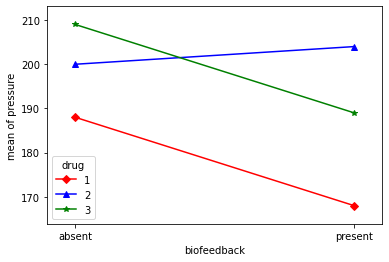

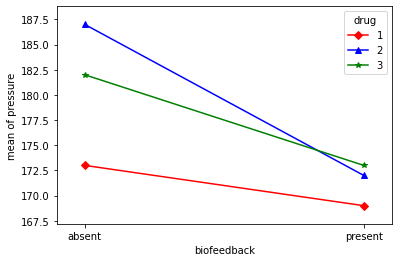

In [ ]:
# diet is Absent
statsmodels.graphics.factorplots.interaction_plot(absent_diet.biofeedback,
                                                  absent_diet.drug,
                                                  absent_diet.pressure,
                                                  colors=['red','blue', 'green'],
                                                  markers=['D','^', '*'])
# diet is Present
statsmodels.graphics.factorplots.interaction_plot(present_diet.biofeedback,
                                                  present_diet.drug,
                                                  present_diet.pressure,
                                                  colors=['red','blue', 'green'],
                                                  markers=['D','^', '*'])
plt.show()

In [ ]:
absent_biofeedback = data[data.biofeedback == 'absent'].reset_index()
present_biofeedback = data[data.biofeedback == 'present'].reset_index()

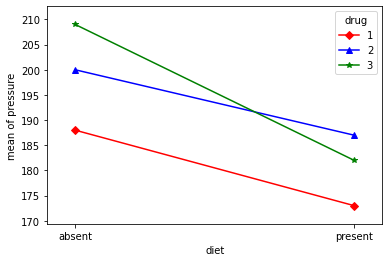

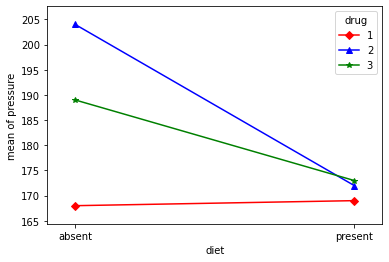

In [ ]:
# biofeedback is Absent
statsmodels.graphics.factorplots.interaction_plot(absent_biofeedback.diet,
                                                  absent_biofeedback.drug,
                                                  absent_biofeedback.pressure,
                                                  colors=['red','blue', 'green'],
                                                  markers=['D','^', '*'])
# biofeedback is Present
statsmodels.graphics.factorplots.interaction_plot(present_biofeedback.diet,
                                                  present_biofeedback.drug,
                                                  present_biofeedback.pressure,
                                                  colors=['red','blue', 'green'],
                                                  markers=['D','^', '*'])
plt.show()

Тройное взаимодействие значимо, поэтому разделим выборку по одному из признаков.  

Двухфакторный дисперсионный анализ для пациентов, проходящих психотерапию:

In [ ]:
pg.anova(dv='pressure', between=['diet', 'drug'], data=present_biofeedback,detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,diet,2209.0,1,2209.000000,15.248504,0.000496,0.336995
1,drug,2342.0,2,1171.000000,8.083295,0.001556,0.350179
2,diet * drug,1634.0,2,817.000000,5.639669,0.008334,0.273244
3,Residual,4346.0,30,144.866667,NaN,NaN,NaN


Есть значимое межфакторное взаимодействие:

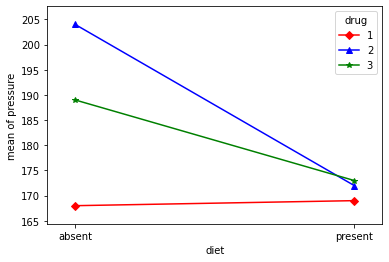

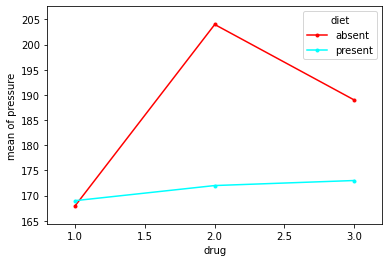

In [ ]:
statsmodels.graphics.factorplots.interaction_plot(present_biofeedback.diet,
                                                  present_biofeedback.drug,
                                                  present_biofeedback.pressure,
                                                  colors=['red','blue', 'green'],
                                                  markers=['D','^', '*'])

statsmodels.graphics.factorplots.interaction_plot(present_biofeedback.drug,
                                                  present_biofeedback.diet,
                                                  present_biofeedback.pressure)
plt.show()

Поэтому снова поделим выборку.  

Однофакторный анализ для пациентов, проходящих психотерапию и сидящих на диете:  

In [ ]:
present_bio_present_diet = present_biofeedback[present_biofeedback.diet == 'present'].reset_index()

<AxesSubplot:xlabel='drug', ylabel='pressure'>

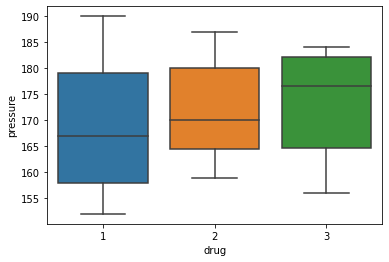

In [ ]:
sns.boxplot(x='drug', y='pressure',data=present_bio_present_diet)

In [ ]:
pg.anova(dv='pressure', between=['drug'], data=present_bio_present_diet,detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,drug,52.0,2,26.0,0.164141,0.850126,0.021417
1,Within,2376.0,15,158.4,NaN,NaN,NaN


Значимых различий между эффектами препаратов нет.  

Однофакторный анализ для пациентов, проходящих психотерапию и не сидящих на диете:  

In [ ]:
present_bio_absent_diet = present_biofeedback[present_biofeedback.diet == 'absent'].reset_index()

<AxesSubplot:xlabel='drug', ylabel='pressure'>

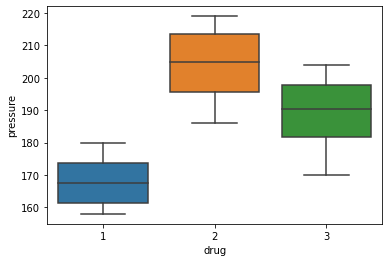

In [ ]:
sns.boxplot(x='drug', y='pressure',data=present_bio_absent_diet)

In [ ]:
pg.anova(dv='pressure', between=['drug'], data=present_bio_absent_diet,detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,drug,3924.0,2,1962.000000,14.939086,0.000269,0.665762
1,Within,1970.0,15,131.333333,NaN,NaN,NaN


Так как использование anova позволяет только отвергать/не отвергать гипотезу о средних, то нам бы хотелось инструмент, позволяющий более конкретно сравнивать группы между собой.

In [ ]:
mc = statsmodels.stats.multicomp.MultiComparison(present_bio_absent_diet['pressure'],
                                                 present_bio_absent_diet['drug'])
mc_results = mc.tukeyhsd()
print(mc_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2     36.0  0.001  18.8206 53.1794   True
     1      3     21.0 0.0163   3.8206 38.1794   True
     2      3    -15.0 0.0918 -32.1794  2.1794  False
-----------------------------------------------------


Препарат из группы 1 значимо отличим от препарата из групп 2 и 3, а препараты из группы 2 и 3 не являются статистически отличимыми на 5% уровне значимости(p-adj 0.001 и 0.01 против 0.09). То есть это дает нам оснавания считать, что препарат 1 значимо эффективнее двух других.  

Аналогично можно провести двухфакторный дисперсионный анализ для пациентов, не проходящих психотерапию:

In [ ]:
pg.anova(dv='pressure', between=['diet','drug'], data=absent_biofeedback,detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,diet,3025.0,1,3025.000,17.956074,0.000198,0.374428
1,drug,1592.0,2,796.000,4.724970,0.016448,0.239543
2,diet * drug,344.0,2,172.000,1.020973,0.372422,0.063727
3,Residual,5054.0,30,168.467,NaN,NaN,NaN


In [ ]:
pg.pairwise_tukey(data=absent_biofeedback, dv='pressure', between='drug')

,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,180.5,193.5,-13.0,6.522,two-sided,-1.993,0.117048,-0.786
1,1,3,180.5,195.5,-15.0,6.522,two-sided,-2.300,0.058436,-0.907
2,2,3,193.5,195.5,-2.0,6.522,two-sided,-0.307,0.900000,-0.121


In [ ]:
pg.pairwise_tukey(data=absent_biofeedback, dv='pressure', between='diet')

,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,absent,present,199.0,180.667,18.333,4.779,two-sided,3.836,0.001,1.25


##Удовлетворенность клиентов банка
https://www.kaggle.com/c/santander-customer-satisfaction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_classif, f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [ ]:
data = pd.read_csv('santander.csv')
data.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [ ]:
X = data.drop('TARGET', axis = 1)
y = data['TARGET']

X.shape, y.shape

((76020, 370), (76020,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [ ]:
constant_filter = VarianceThreshold(threshold= 0.01)
constant_filter.fit(X_train)
X_train_filter = constant_filter.transform(X_train)
X_test_filter = constant_filter.transform(X_test)

In [ ]:
X_train_filter.shape, X_test_filter.shape

((60816, 274), (15204, 274))

In [ ]:
X_train_T = pd.DataFrame(X_train_filter.T)
X_test_T = pd.DataFrame(X_test_filter.T)

In [ ]:
X_train_T.duplicated().sum()

17

In [ ]:
duplicated_features = X_train_T.duplicated()

In [ ]:
features_to_keep = [not index for index in duplicated_features]
X_train_unique = X_train_T[features_to_keep].T
X_test_unique = X_test_T[features_to_keep].T

In [ ]:
X_train_unique.shape, X_test_unique.shape

((60816, 257), (15204, 257))

In [ ]:
sel = f_classif(X_train_unique, y_train)

In [ ]:
p_values = pd.Series(sel[1])
p_values.index = X_train_unique.columns
p_values.sort_values(ascending = True, inplace = True)

<Axes: >

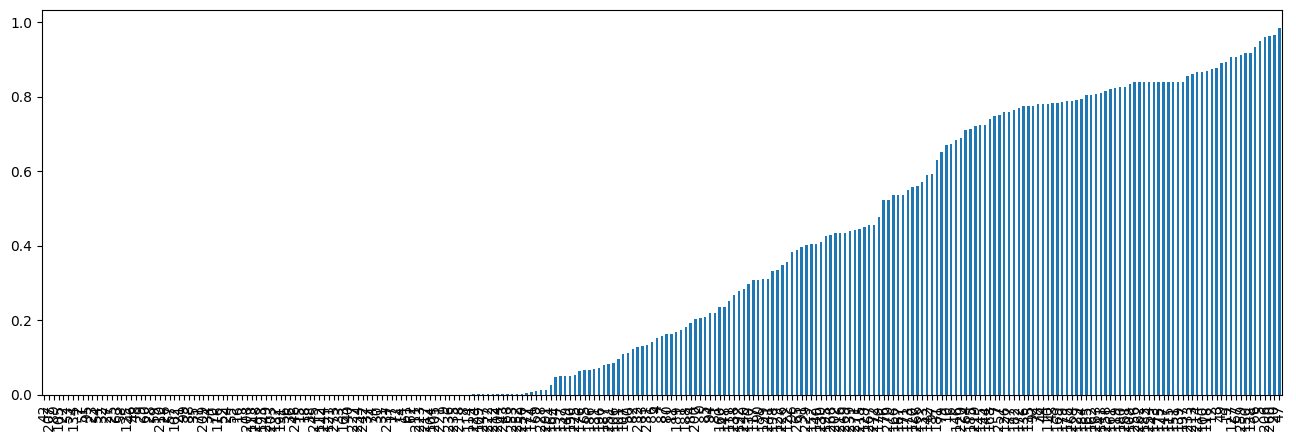

In [ ]:
p_values.plot.bar(figsize = (16,5))

In [ ]:
p_values = p_values[p_values<1e-21]
len(p_values.index)

17

In [ ]:
X_train_p = X_train_unique[p_values.index]
X_test_p = X_test_unique[p_values.index]

In [ ]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X_train_unique, y_train)
mi /= np.max(mi)

<Axes: >

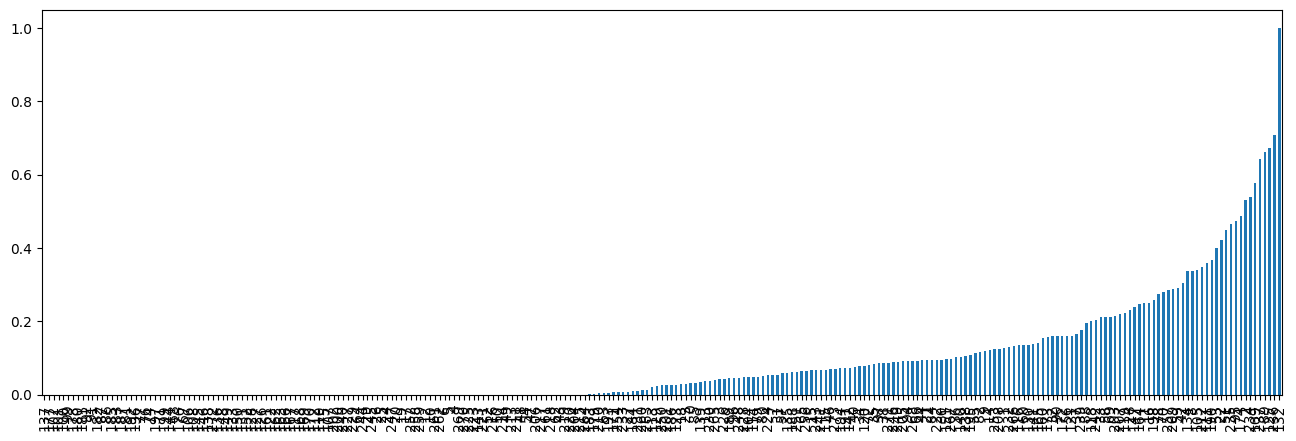

In [ ]:
mi_values = pd.Series(mi)
mi_values.index = X_train_unique.columns
mi_values.sort_values(ascending = True, inplace = True)
mi_values.plot.bar(figsize = (16,5))

In [ ]:
mi_values = mi_values[mi_values>0.5]
len(mi_values.index)

8

In [ ]:
X_train_mi = X_train_unique[mi_values.index]
X_test_mi = X_test_unique[mi_values.index]

In [ ]:
def run_RandomForest(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(n_estimators = 200, random_state = 0, n_jobs = -1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))

In [ ]:
%%time
run_RandomForest(X_train_p, X_test_p, y_train, y_test)

Accuracy:  0.9585635359116023
CPU times: user 10.1 s, sys: 104 ms, total: 10.2 s
Wall time: 5.46 s


In [ ]:
%%time
run_RandomForest(X_train, X_test, y_train, y_test)

Accuracy:  0.9579058142594055
CPU times: user 1min 4s, sys: 326 ms, total: 1min 5s
Wall time: 36.6 s


In [ ]:
%%time
run_RandomForest(X_train_mi, X_test_mi, y_train, y_test)

Accuracy:  0.9588266245724809
CPU times: user 20.4 s, sys: 98.7 ms, total: 20.5 s
Wall time: 12 s
